In [1]:
import numpy as np
import pandas as pd
import pymc3
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')

In [3]:
maxima = data.groupby(data.month).max().dropna(axis=1)
maxima

,timestamp,Torq,Cut_Err,Cut_Pos,Cut_Spd,Film_Pos,Film_Spd,Film_Err,vax,day,hour,min,sec,sample,mode
month,,,,,,,,,,,,,,,
1,8.199999,1.895013,1.570941,1027139512,11645.507812,1453670694,16170.039062,2.959732,3179.999512,31,22,59,58,94,5
2,8.199999,1.842287,1.602093,729746391,17928.312500,225955103,16326.077148,3.567880,3599.999512,30,17,59,58,169,5
3,8.199999,1.576833,1.652966,604495256,16726.683594,162159208,16620.535156,2.779439,3599.999512,22,18,59,58,201,5
4,8.199999,1.792306,1.739299,1911789016,17035.673828,336100494,16789.156250,3.390853,3479.999512,26,17,59,59,263,8
5,8.195999,1.761793,1.616148,300935777,11655.806641,317632838,16864.658203,3.346200,3299.999512,26,18,59,55,283,5
6,8.199999,1.806132,1.620048,494764215,11247.252930,288634200,16763.988281,3.197907,3299.999512,29,18,57,59,312,6
7,8.195999,1.732314,1.372040,249087353,11322.784180,260084821,16763.990234,3.471120,3299.999512,26,17,59,59,350,6
8,8.195999,1.748458,1.418344,413615190,11590.576172,219609839,16769.023438,3.338594,3299.999512,30,19,57,59,414,5
9,8.195999,1.900483,1.324164,99955624,9891.127930,236204058,5660.143066,1.616388,1799.999756,19,16,57,58,427,1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:05<00:00, 30.39draws/s] 
The acceptance probability does not match the target. It is 0.9987239222059385, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


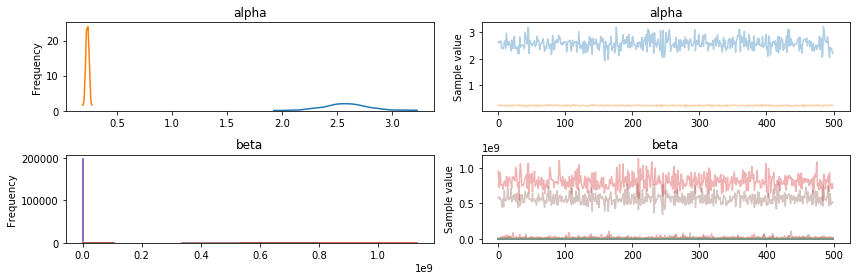

In [4]:
r = 10 
reduced_maxima = maxima[maxima.columns[0:r]]
t = reduced_maxima.shape[0] # Number of observations per site

with pymc3.Model() as model:
    alpha = pymc3.InverseGamma('alpha',alpha = 1.0, beta = 1.0)
    beta  = pymc3.Lognormal('beta',mu = 2.0, sd = 2.0, shape = r)
    x     = pymc3.Weibull('x',alpha = alpha, beta = beta, shape=[t,r],observed = reduced_maxima )
    trace = pymc3.sample()
    _ = pymc3.traceplot(trace)


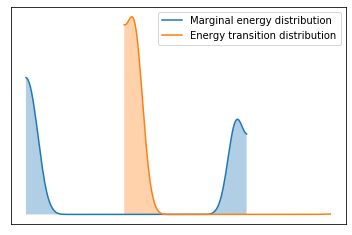

In [5]:
pymc3.energyplot(trace);


In [6]:
pymc3.bfmi(trace)

0.004617400881336311

In [7]:
max(np.max(gr_stats) for gr_stats in pymc3.gelman_rubin(trace).values())

11.034557874599095

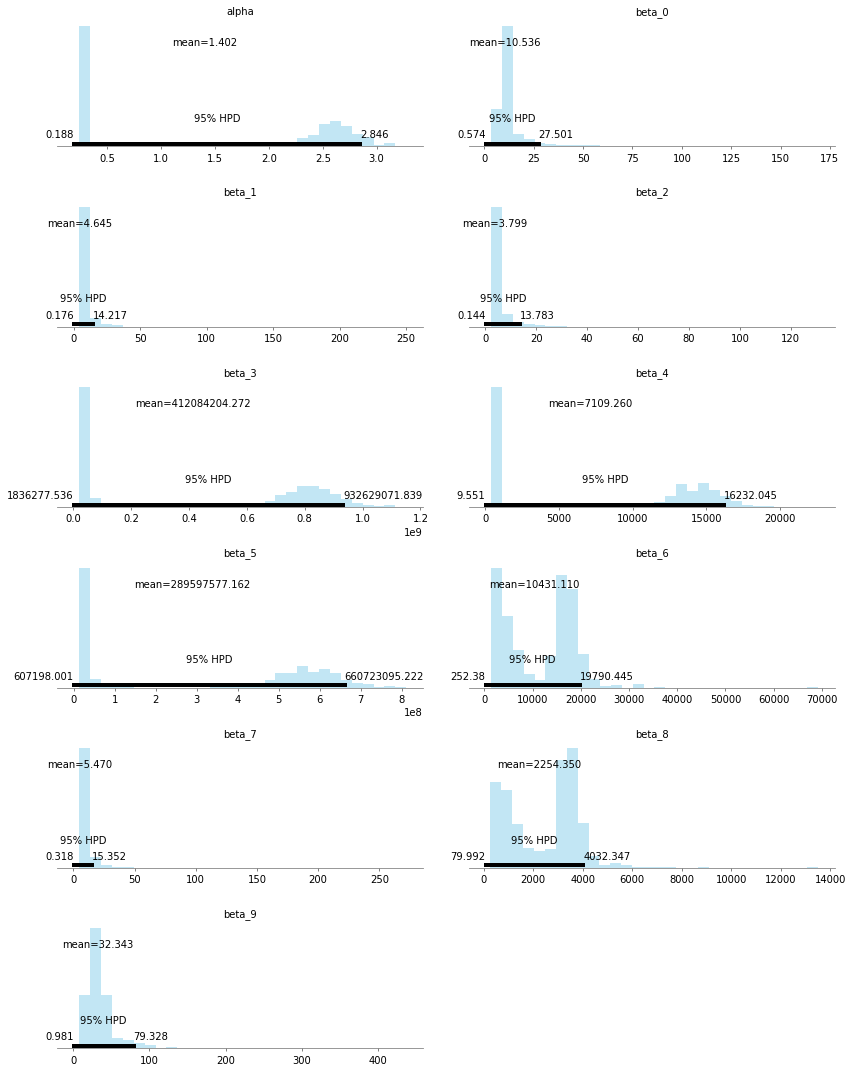

In [8]:
pymc3.plot_posterior(trace, lw=0, alpha=0.5);

In [10]:
with model:
    ppc = pymc3.sample_ppc(
        trace, samples=1500, vars=[x]
    )

100%|██████████| 1500/1500 [00:00<00:00, 4635.04it/s]


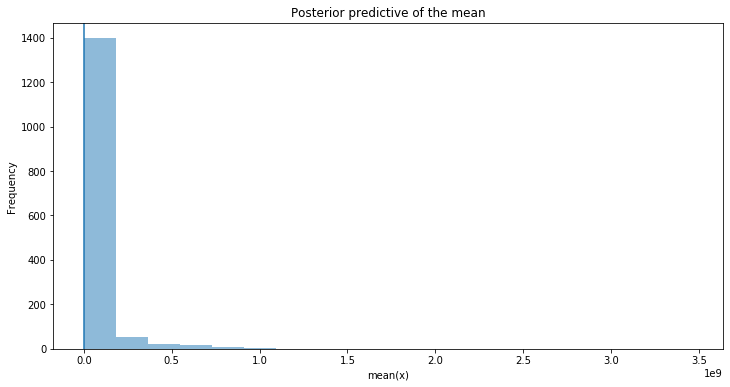

In [18]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([y.mean() for y in ppc['x']], bins=19, alpha=0.5)
ax.axvline(data['month'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [22]:
R2_ = pymc3.stats.r2_score(data['month'].values.reshape(1,1062912),trace['x'])
WAIC_ = pymc3.stats.waic(trace,model)
#print(R2_)
print(WAIC_)

WAIC_r(WAIC=2479.095558380906, WAIC_se=171.24315936082644, p_WAIC=223.206782713795, var_warn=1)


/Users/RishJain04/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/Users/RishJain04/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [25]:
pymc3.summary(trace, varnames=['alpha', 'beta']).round(2)

/Users/RishJain04/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:974: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.400000e+00,1.180000e+00,0.12,0.19,2.850000e+00,1.01,11.03
beta__0,1.054000e+01,1.113000e+01,0.39,0.57,2.750000e+01,238.43,1.04
beta__1,4.650000e+00,1.022000e+01,0.47,0.18,1.422000e+01,31.69,1.04
beta__2,3.800000e+00,7.600000e+00,0.38,0.14,1.378000e+01,12.88,1.08
beta__3,4.120842e+08,4.018286e+08,39633424.52,1836277.54,9.326291e+08,1.02,8.17
beta__4,7.109260e+03,7.191260e+03,710.63,9.55,1.623204e+04,1.02,8.83
beta__5,2.895976e+08,2.820303e+08,27769407.97,607198.00,6.607231e+08,1.02,7.70
beta__6,1.043111e+04,7.376500e+03,614.98,252.38,1.979044e+04,1.32,2.13
beta__7,5.470000e+00,1.062000e+01,0.41,0.32,1.535000e+01,38.96,1.04
beta__8,2.254350e+03,1.450320e+03,108.58,79.99,4.032350e+03,1.57,1.74
